# Inference of the radial Z-effective profile

In this example, we demonstrate how the radial profile of Z-effective can be inferred by combining radial measurements of the electron temperature and density from a Thomson scattering diagnostic, and radial measurements of bremsstrahlung emission from a filtered imaging diagnostic.

First, we can import the synthetic data we've created for this example and plot it:

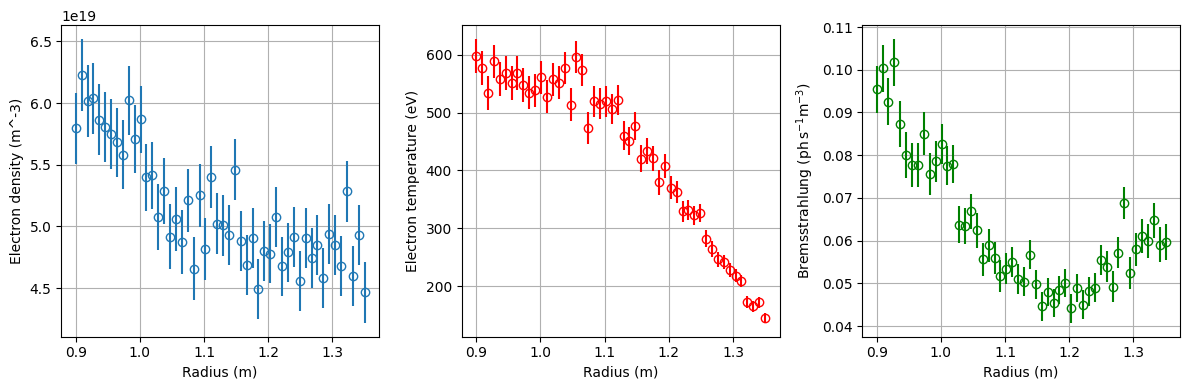

In [1]:
# import the synthetic diagnostic data and associated uncertainties
from example_data import brem_measurements, brem_sigma, measurement_radius
from example_data import te_measurements, ne_measurements, te_sigma, ne_sigma


import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

data_style = dict(marker="o", linestyle="none", markerfacecolor="none")

ax1.errorbar(measurement_radius, ne_measurements, yerr=ne_sigma, c="C0", **data_style)
ax1.set_xlabel("Radius (m)")
ax1.set_ylabel("Electron density (m^-3)")
ax1.grid()

ax2.errorbar(measurement_radius, te_measurements, yerr=te_sigma, c="red", **data_style)
ax2.set_xlabel("Radius (m)")
ax2.set_ylabel("Electron temperature (eV)")
ax2.grid()

ax3.errorbar(measurement_radius, brem_measurements, yerr=brem_sigma, c="green", **data_style)
ax3.set_xlabel("Radius (m)")
ax3.set_ylabel(r"Bremsstrahlung $(\mathrm{ph \, s^{-1} m^{-3})}$")
ax3.grid()

fig.tight_layout()
plt.show()

A MIDAS analysis follows the following steps:

 - Create a `DiagnosticLikelihood` instance for each diagnostic included in the analysis.

 - Create a `FieldModel` instance for each field which is requested by one of the diagnostic models.

 - Specify the prior distribution using classes from the `midas.priors` module (or implement your own using the `BasePrior` base-class).

 - Build the parametrisation for the posterior distribution by calling the `PlasmaState.build_posterior()` function.

 - Use the functions in the `midas.posterior` module to evaluate the posterior distribution, allowing for MAP estimation or sampling.


## Adding diagnostics to a MIDAS analysis

To include a diagnostic in a MIDAS analysis, we need to create a `DiagnosticLikelihood`
object. MIDAS abstracts the definition of a diagnostic likelihood into two parts:


* A `DiagnosticModel` object, which implements (or calls)
  the forward-model for the diagnostic, and specifies what information is required to
  evaluate the model predictions (e.g. the values of plasma fields like temperature or
  density at specific coordinates).


* A `LikelihoodFunction` object, which holds the experimental
  measurements and uncertainties, and specifies a distribution used to model the
  uncertainties (e.g. Gaussian, logistic etc.)


### Defining diagnostic models
In MIDAS, diagnostic models are classes which inherit from an abstract base-class `DiagnosticModel`. This class can fully implement a forward-model of a diagnostic, or act as a light wrapper around a model implemented elsewhere, allowing that model to interact with MIDAS.

In this example, we will use an existing physics code which models the bremsstrahlung emission $\mathcal{E}$ as
$$
\mathcal{E} = a Z_{\mathrm{eff}} n_e^2 \frac{G(T_e)}{\lambda^2 \sqrt{T_e}} \exp{\left[ - \frac{b}{\lambda T_e}\right]}.
$$
Here $a$, $b$ are known constants, and for simplicity we'll assume our bremsstrahlung measurements were collected at a single fixed wavelength $\lambda$.

Therefore, to make predictions of our measured bremsstrahlung, we need to specify the Z-effective $Z_{\mathrm{eff}}$, electron temperature $T_e$ and electron density $n_e$ at the appropriate radial positions.

To communicate to MIDAS that the values of these fields are required inputs to the model, we use the `self.fields` instance attribute of our model class. `self.fields` is always an instance of the `Fields` class, which accepts a series of `FieldRequests` as arguments. Each instance of `FieldRequest` allows us to request the values of a particular field at a given set of coordinates.

The `DiagnosticModel` base-class also has two abstract methods, `predictions` and `predictions_and_jacobians`, which MIDAS will call when evaluating the posterior log-probability or its derivative. The values of any fields or parameters required by the model are passed to these methods using the names of the fields and parameters.

We can now implement a diagnostic model for the Bremsstrahlung measurements as follows:

In [2]:
# import our existing physics model
from diagnostics import bremsstrahlung_model, bremsstrahlung_jacobian

# import the midas components that we'll need to build a diagnostic model
from midas import Fields, FieldRequest, Parameters
from midas.models import DiagnosticModel

from numpy import ndarray


class BremsstrahlungModel(DiagnosticModel):
    def __init__(self, radius: ndarray, wavelength: float):
        self.wavelength = wavelength

        # Set the 'fields' attribute to request the field values the model needs
        self.fields = Fields(
            FieldRequest(name="te", coordinates={"radius": radius}),
            FieldRequest(name="ne", coordinates={"radius": radius}),
            FieldRequest(name="z_eff", coordinates={"radius": radius}),
        )

        # The model has no additional parameters, so the self.parameters instance
        # attribute is set to an empty instance of the 'Parameters' class.
        self.parameters = Parameters()

    def predictions(self, te: ndarray, ne: ndarray, z_eff: ndarray) -> ndarray:
        # We set the arguments of the predictions function to be the names of
        # the fields we requested using the self.fields instance attribute.

        # now we have access to all the information needed to call the physics
        # model and return its output.
        return bremsstrahlung_model(
            Te=te,
            Ne=ne,
            zeff=z_eff,
            wavelength=self.wavelength,
        )

    def predictions_and_jacobians(
            self, te: ndarray, ne: ndarray, z_eff: ndarray
    ) -> tuple[ndarray, dict[str, ndarray]]:
        # this function must return the predictions and the jacobians of the
        # predictions, i.e. the derivative of each prediction value with
        # respect to each input value.

        # call our physics model to get the predictions and the jacobians
        predictions, te_jac, ne_jac, z_eff_jac = bremsstrahlung_jacobian(
            Te=te,
            Ne=ne,
            zeff=z_eff,
            wavelength=self.wavelength,
        )

        # we return the jacobians as a dictionary mapping the input names to
        # their respective jacobian matrix.
        jacobians = {
            "te": te_jac,
            "ne": ne_jac,
            "z_eff": z_eff_jac,
        }

        return predictions, jacobians


Now we've defined our bremsstrahlung model class, we can create an instance of it to be used by MIDAS:

In [3]:

brem_forward_model = BremsstrahlungModel(
    radius=measurement_radius,
    wavelength=569e-9,
)


### Specifying a likelihood model for diagnostic data
...

In [4]:
from midas.likelihoods import GaussianLikelihood

brem_likelihood = GaussianLikelihood(
    y_data=brem_measurements,
    sigma=brem_sigma,
)

Now we have built the two necessary components, we can create a `DiagnosticLikelihood` instance to represent our bremsstrahlung diagnostic:

In [5]:
from midas.likelihoods import DiagnosticLikelihood

brem_diagnostic = DiagnosticLikelihood(
    likelihood=brem_likelihood,
    diagnostic_model=brem_forward_model,
    name="brem_diagnostic"
)

We can now repeat this process and create `DiagnosticLikelihood` instances to represent diagnostic models for the electron temperature and density data:

In [6]:
# for brevity, here we import a model for the Thomson scattering profile data
from diagnostics import ThomsonModel

# build the electron temperature diagnostic likelihood
te_likelihood = GaussianLikelihood(
    y_data=te_measurements,
    sigma=te_sigma,
)

te_forward_model = ThomsonModel(
    radius=measurement_radius,
    field="te"
)

te_diagnostic = DiagnosticLikelihood(
    likelihood=te_likelihood,
    diagnostic_model=te_forward_model,
    name="te_diagnostic"
)

# build the electron density diagnostic likelihood
ne_likelihood = GaussianLikelihood(
    y_data=ne_measurements,
    sigma=ne_sigma,
)

ne_forward_model = ThomsonModel(
    radius=measurement_radius,
    field="ne"
)

ne_diagnostic = DiagnosticLikelihood(
    likelihood=ne_likelihood,
    diagnostic_model=ne_forward_model,
    name="ne_diagnostic"
)

## Specifying models for the requested fields
...

In [7]:
from numpy import linspace
from midas.models.fields import ExSplineField, CubicSplineField

ts_knots = linspace(0.9, 1.35, 6)
ne_field = ExSplineField(
    field_name="ne",
    axis_name="radius",
    axis=ts_knots,
)

te_field = ExSplineField(
    field_name="te",
    axis_name="radius",
    axis=ts_knots,
)

z_eff_knots = linspace(0.9, 1.35, 5)
z_eff_field = CubicSplineField(
    field_name="z_eff",
    axis=z_eff_knots,
    axis_name="radius"
)

### Specifing the prior distribution
...

In [8]:
from midas.priors import SoftLimitPrior
from midas.operators import derivative_operator
te_request = FieldRequest(name="te", coordinates={"radius": measurement_radius})
operator = derivative_operator(measurement_radius, order=1)

te_monotonicity_prior = SoftLimitPrior(
    name="te_monotonicity_prior",
    field_request=te_request,
    upper_limit=0.0,
    standard_deviation=30.,
    operator=operator
)

### Building the posterior
...

In [9]:
from midas import PlasmaState

PlasmaState.build_posterior(
    diagnostics=[brem_diagnostic, te_diagnostic, ne_diagnostic],
    priors=[te_monotonicity_prior],
    field_models=[te_field, ne_field, z_eff_field]
)

Now the parametrisation for the posterior distribution has been built, we can import the `posterior` module:

In [10]:
from midas import posterior

[build initial guess]

In [11]:
from numpy import full, log

initial_guess_dict = {
    'ln_ne_bspline_basis': full(ts_knots.size, fill_value=log(5e19)),
    'ln_te_bspline_basis': full(ts_knots.size, fill_value=log(60.)),
    'z_eff_cubic_spline': full(z_eff_knots.size, fill_value=1.2),
}
initial_guess_array = PlasmaState.merge_parameters(initial_guess_dict)

[build bounds]

In [12]:
bounds_dict = {
    'ln_ne_bspline_basis': (log(1e17), log(1e21)),
    'ln_te_bspline_basis': (log(2), log(1000)),
    'z_eff_cubic_spline': (1.0, 5.0),
}

bounds = PlasmaState.build_bounds(bounds_dict)

[find map]

In [13]:
from scipy.optimize import minimize

opt_result = minimize(
    fun=posterior.cost,
    x0=initial_guess_array,
    method='L-BFGS-B',
    bounds=bounds,
    jac=posterior.cost_gradient,
)

[plot map results]

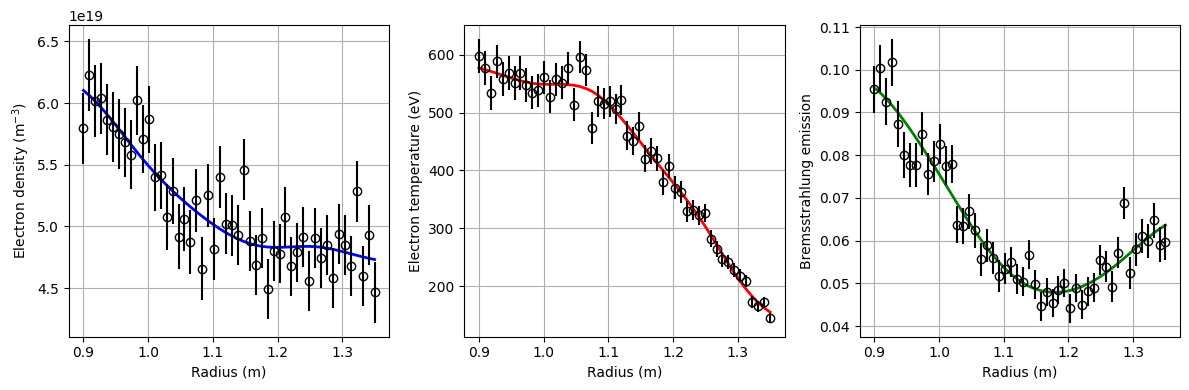

In [14]:
map_predictions = posterior.get_model_predictions(opt_result.x)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

data_style = dict(marker="o", linestyle="none", markerfacecolor="none", color="black")

ax1.plot(measurement_radius, map_predictions["ne_diagnostic"], color="blue", lw=2)
ax1.errorbar(measurement_radius, ne_measurements, yerr=ne_sigma, **data_style)
ax1.set_xlabel("Radius (m)")
ax1.set_ylabel(r"Electron density $(\mathrm{m}^{-3})$")
ax1.grid()

ax2.plot(measurement_radius, map_predictions["te_diagnostic"], color="red", lw=2)
ax2.errorbar(measurement_radius, te_measurements, yerr=te_sigma, **data_style)
ax2.set_xlabel("Radius (m)")
ax2.set_ylabel("Electron temperature (eV)")
ax2.grid()

ax3.plot(measurement_radius, map_predictions["brem_diagnostic"], c="green", lw=2)
ax3.errorbar(measurement_radius, brem_measurements, yerr=brem_sigma, **data_style)
ax3.set_xlabel("Radius (m)")
ax3.set_ylabel("Bremsstrahlung emission")
ax3.grid()

fig.tight_layout()
plt.show()

[run mcmc]

In [15]:
from inference.mcmc import HamiltonianChain
from inference.approx import conditional_moments

_, conditional_variance = conditional_moments(
    posterior=posterior.log_probability,
    conditioning_point=opt_result.x,
    bounds=[b for b in bounds],
)

chain = HamiltonianChain(
    posterior=posterior.log_probability,
    grad=posterior.gradient,
    start=opt_result.x,
    inverse_mass=conditional_variance,
    bounds=(bounds[:, 0], bounds[:, 1]),
    epsilon=0.25
)
chain.steps = 15

In [16]:
chain.advance(5000)

  advancing chain:   [ complete - 5000 steps taken in 0:00:10 ]      


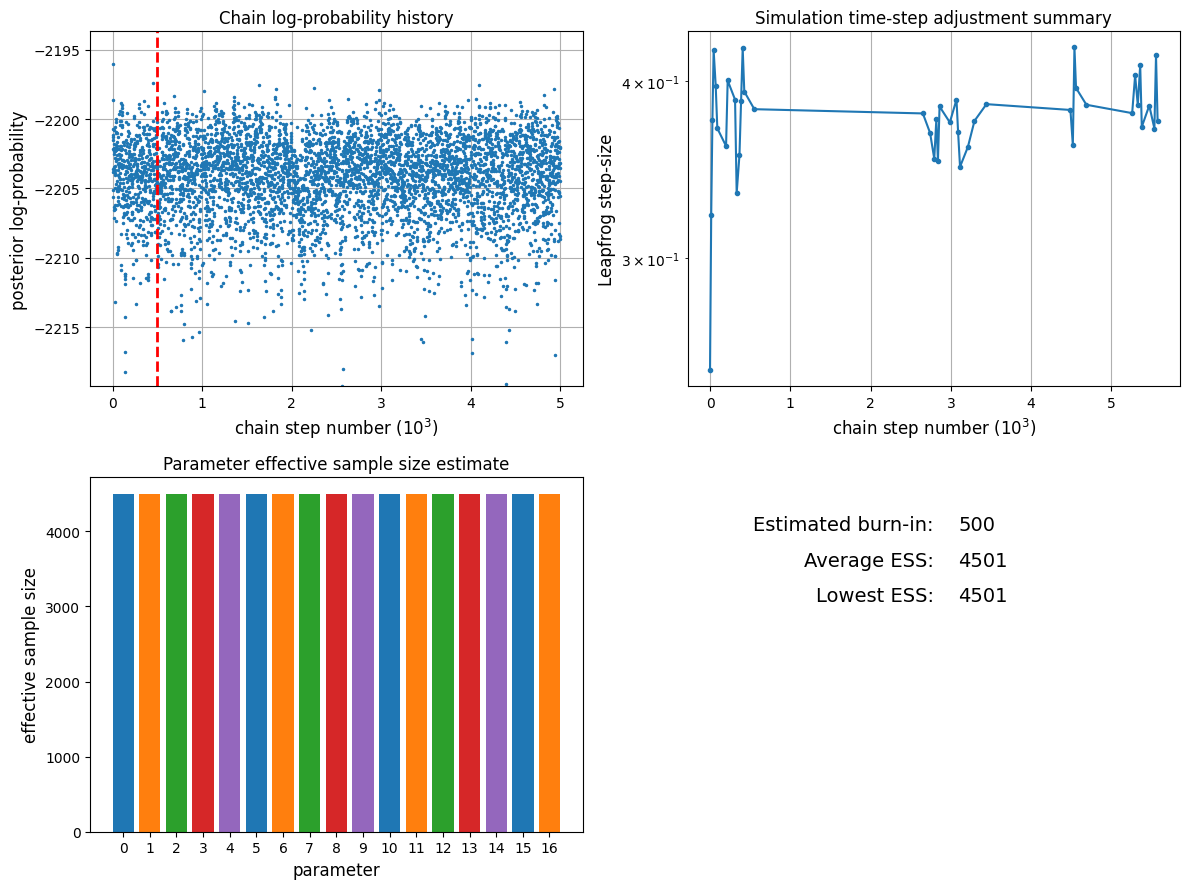

In [17]:
chain.plot_diagnostics(burn=500)

In [18]:
sample = chain.get_sample(burn=500, thin=1)

[calculate field value samples]

In [19]:
profile_axis = linspace(0.9, 1.35, 128)

te_profiles = posterior.sample_field_values(
    parameter_samples=sample,
    field_request=FieldRequest("te", coordinates={"radius": profile_axis}),
)

ne_profiles = posterior.sample_field_values(
    parameter_samples=sample,
    field_request=FieldRequest("ne", coordinates={"radius": profile_axis}),
)

z_eff_profiles = posterior.sample_field_values(
    parameter_samples=sample,
    field_request=FieldRequest("z_eff", coordinates={"radius": profile_axis}),
)

[plot mcmc results]

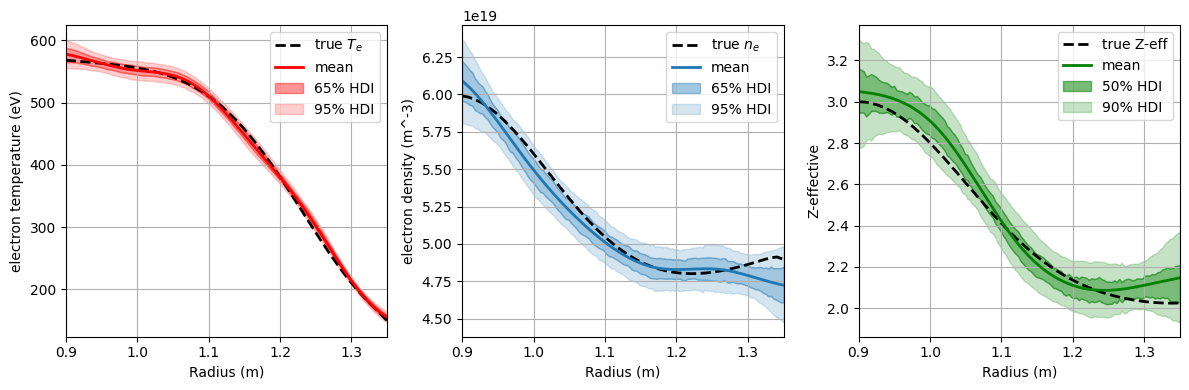

In [20]:
from example_data import true_z_eff_profile, true_te_profile, true_ne_profile
from inference.plotting import hdi_plot


fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(measurement_radius, true_te_profile, lw=2, color="black", ls="dashed", label=r"true $T_e$")
hdi_plot(profile_axis, te_profiles, axis=ax1, color="red")
ax1.set_xlabel("Radius (m)")
ax1.set_ylabel("electron temperature (eV)")
ax1.set_xlim([0.9, 1.35])
ax1.grid()
ax1.legend()

ax2.plot(measurement_radius, true_ne_profile, lw=2, color="black", ls="dashed", label=r"true $n_e$")
hdi_plot(profile_axis, ne_profiles, axis=ax2, color="C0")
ax2.set_xlabel("Radius (m)")
ax2.set_ylabel("electron density (m^-3)")
ax2.set_xlim([0.9, 1.35])
ax2.grid()
ax2.legend()

ax3.plot(measurement_radius, true_z_eff_profile, lw=2, color="black", ls="dashed", label="true Z-eff")
hdi_plot(profile_axis, z_eff_profiles, axis=ax3, color="green", intervals=[0.9, 0.5])
ax3.set_xlabel("Radius (m)")
ax3.set_ylabel("Z-effective")
ax3.set_xlim([0.9, 1.35])
ax3.grid()
ax3.legend()

plt.tight_layout()
plt.show()